In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<h3>Define Utility Functions </h3>


Show_In_Notebook function to show opencv image with matplotlib

In [3]:
def show_in_notebook(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

<h3> Using Four Pre-Labeled Points to do Perspective Transformation

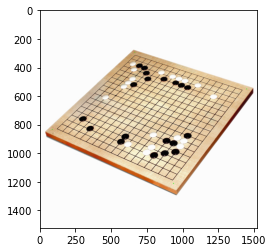

In [4]:
# read the labeled image
img = cv2.imread('../img/go_board.png',1)
show_in_notebook(img)
h, w, ch = img.shape
# Find the green labeled point
green_low = np.array([0, 220, 0])
green_high = np.array([10, 255, 10])
mask = cv2.inRange(img, green_low, green_high)

# coord contains all the pixel coordinates showing green color
coord = cv2.findNonZero(mask)
# convert coord to np_array format
coord_xy = [[dot[0][0],dot[0][1]] for dot in coord]
np_coord = np.array(coord_xy)

In [5]:
# Used K-Means to cluster the green pixels to four dots
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(np_coord)

# To show clustered centers, use
kmeans.cluster_centers_

array([[ 932.88235294, 1211.41176471],
       [1444.0952381 ,  550.9047619 ],
       [  85.64285714,  833.78571429],
       [ 661.66666667,  295.55555556]])

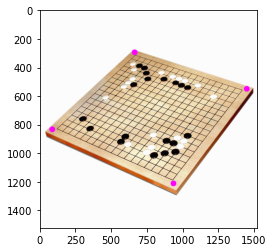

In [6]:
image = cv2.imread('../img/go_board.jpeg')
for dot in kmeans.cluster_centers_:
    image = cv2.circle(image, (int(dot[0]),int(dot[1])), 20, (255, 0, 255), -1)
show_in_notebook(image)

# kmeans.cluster_centers_[0][0]

<p>Since the kmeans function returns the corner points in a random order, we need to sort the four points in the order of<\p>

<p>(UPPER-LEFT, UPPER-RIGHT, LOWER-RIGHT, LOWER-LEFT)<\p>

In [7]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    rect[0] = pts[2]
    rect[1] = pts[0]
    rect[2] = pts[1]
    rect[3] = pts[3]
    return rect

rect = order_points(kmeans.cluster_centers_)
rect

array([[  85.64286,  833.7857 ],
       [ 932.8823 , 1211.4117 ],
       [1444.0952 ,  550.9048 ],
       [ 661.6667 ,  295.55554]], dtype=float32)

In [8]:
# By default, use the cluster centers to rectify the image
def four_point_transform(image, pts = kmeans.cluster_centers_):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

<h4> Demo of Rectifying the Image

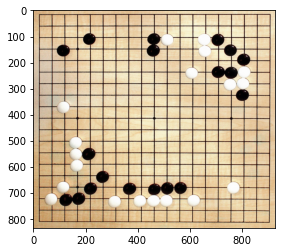

In [9]:
image = cv2.imread('../img/go_board.jpeg')
pts = kmeans.cluster_centers_
warped = four_point_transform(image, pts)
show_in_notebook(warped)